In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [112]:
from random import seed
seed(17)

rng = np.random.RandomState(19)

Data source: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [113]:
# Upload data
data = pd.read_csv("/content/application_record.csv")
credit = pd.read_csv("/content/credit_record.csv")


In [114]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [115]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [116]:
print(len(data['ID'].unique()))
print(len(credit['ID'].unique()))

438510
45985


In [117]:
# Designate those who are late with a loan payment for a month or more as bad (status = 1)
credit['target'] = None
credit.loc[credit['STATUS'] =='2', 'target'] = 1
credit.loc[credit['STATUS'] =='3', 'target'] = 1
credit.loc[credit['STATUS'] =='4', 'target'] = 1
credit.loc[credit['STATUS'] =='5', 'target'] = 1

In [118]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,target
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None


In [119]:
# Leave only those people about whom we have data on whether they missed a loan payment or paid on time
grouped = credit.groupby('ID').count()
grouped['target'][grouped['target'] > 0] = 1
grouped['target'][grouped['target'] == 0] = 0
grouped = grouped[['target']]
data_new = pd.merge(data, grouped, how='inner', on='ID')
data_new['target'] = data_new['target']

In [120]:
# Clean NA
data_new = data_new.dropna(axis=0, how='any', subset=None, inplace=False)
data_new['target'].value_counts()

,count
target,
0,24712
1,422


In [121]:
# Several categorical features, they need to be replaced with numbers
data_new.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [122]:
ord_enc = OrdinalEncoder()
for feature in ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE',\
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']:
    data_new.loc[:,feature] = ord_enc.fit_transform(data_new[[feature]]).ravel()
data_new.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
2,5008806,1.0,1.0,1.0,0,112500.0,4.0,4.0,1.0,1.0,-21474,-1134,1,0,0,0,16.0,2.0,0
3,5008808,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
4,5008809,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
5,5008810,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
6,5008811,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0


In [123]:
data_new.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
2,5008806,1.0,1.0,1.0,0,112500.0,4.0,4.0,1.0,1.0,-21474,-1134,1,0,0,0,16.0,2.0,0
3,5008808,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
4,5008809,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
5,5008810,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0
6,5008811,0.0,0.0,1.0,0,270000.0,0.0,4.0,3.0,1.0,-19110,-3051,1,0,1,1,14.0,1.0,0


In [124]:
# Create X, Y
X = data_new[data_new.columns[:-1]]
Y = data_new['target']
counter = Counter(Y)
print(counter)

# Divide into test and train 1:4
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10086)
X_train.shape, X_test.shape

# Make train balanced
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_balance, Y_balance = pipeline.fit_resample(X_train, y_train)
counter = Counter(Y_balance)
print(counter)

Counter({0: 24712, 1: 422})
Counter({0: 3952, 1: 1976})


In [131]:
# Random Forest
model = RandomForestClassifier(n_estimators=250, max_depth=12, min_samples_leaf=16)
model.fit(X_balance, Y_balance)
y_predict = model.predict(X_test)

print('Balanced accuracy score is {:.5}'.format(balanced_accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Balanced accuracy score is 0.53557
      0   1
0  4935  10
1    76   6


In [133]:
for col in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
              'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']:
    if col in X_balance.columns:
        X_balance[col] = X_balance[col].astype('category')

In [134]:
for col in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
              'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

In [135]:
# Implement the gradient boosting algorithm for comparison
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8,
                      subsample=0.8,
                      learning_rate =0.02,
                      seed=42, enable_categorical=True)
model.fit(X_balance, Y_balance)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(balanced_accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.50142
    0     1
0  14  4931
1   0    82


Accuracy Score is a bit lower than for random forest.

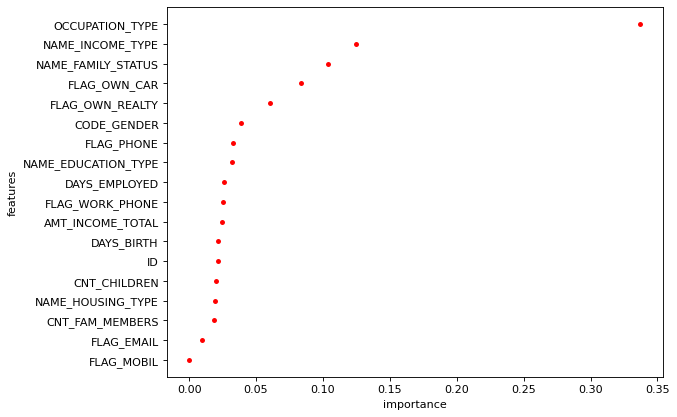

In [136]:
# Plot a graph of feature importance
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True,ascending=False)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance',
    ylabel='features')
plt.figure(figsize=(8, 6), dpi=80)
plot_importance(model, X_train,20)

Three most important features - occupation type, income type and family status